In [1]:
#basic imports
import pandas as pd
import numpy as np
import math
#ml stuff
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Model
from keras.models import Sequential
#metrics + sklearn
from scipy import spatial
from hdbscan import HDBSCAN
from sklearn import metrics
from sklearn import decomposition
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import numpy as np 
#data visualization
import plotly.graph_objs as go
import plotly
import hiplot as hip

C:\Users\madke\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#aware merge will strip down to 120
aware = pd.read_csv('/users/madke/downloads/aware_personality_8-4.csv', index_col = 0)
awaregb = aware.groupby('participantID')


aware['localDate'] =pd.to_datetime(aware.localDate)
aware = aware.loc[:, aware.isna().mean() < .40]

sequences = []
for i in list(set(aware['participantID'])):
    unit = awaregb.get_group(i)
    unit = unit.sort_values(by='localDate')
    unit = unit.reset_index(drop = True)
    sequences.append(unit.reset_index(drop = False))


imp_seq = []
for i in sequences:
    needs_fixed = i.iloc[:,2:(len(i.columns)-10)]
    fixed = needs_fixed.fillna(needs_fixed.mean())
    fixed = fixed.fillna(0)
    new = pd.concat([i.iloc[:,0:2], fixed, i.iloc[:, (len(i.columns)-10):(len(i.columns))]], axis = 1)
    imp_seq.append(new)
  

In [3]:
dep_vars = []
indep_vars = []
for i in imp_seq:
    dep = i.iloc[:, (len(i.columns)-10):(len(i.columns))]
    dep = dep.iloc[:1, :]
    dep_vars.append(np.array(dep))
    indep = i.iloc[:, 0:len(i.columns)-10].drop(['participantID', 'localDate'], axis = 1)
    indep_vars.append(indep)
#here is padding the values for nns (same size 90th percentile)
pad_imp = []
for i in indep_vars:
    if len(i['index']) >= 21:
        pad_imp.append(np.array(i.iloc[0:21,:]))
    else:
        count = 21 - len(i['index'])
        for z in range(0,count):
            i.loc[len(i)] = 0
        pad_imp.append(np.array(i))
    

In [20]:
# split a  sequence into samples
#https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
def split_sequence(sequence, n_steps = 3):
    X, y = list(), list()
    for i in range(sequence.shape[0]):
# find the end of this pattern
        end_ix = i + n_steps
    # check if we are beyond the sequence
        if end_ix > sequence.shape[0] -1:
            break
            # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
 
# this function does not actually create a hiplot object, but converts keras history into a list of dictionaries interperable
#by hiplot.  takes the history object and a series of relevant labels
def create_hiplot(hist_ob, activ, lr, KI, lf, random_state):
    hist_df = pd.DataFrame(hist_ob.history)
    hist = hist_df.to_dict('records')
    trial_num = 0
    for i in hist:
        dict1 = {'activation': activ, 'lr': lr, 'KI': KI, 'lossfxn': lf, 'random_state': random_state, 'epoch': trial_num}
        trial_num +=1
        i = i.update(dict1)
    return(hist)

#this allows you to add multiple history objects to the input for hiplot (desirable for comparing models)       
def update_hiplot(hipl, hist_ob, activ, lr, KI, lf, random_state):
    hist_df = pd.DataFrame(hist_ob.history)
    hist = hist_df.to_dict('records')
    trial_num = 0
    for i in hist:
        dict1 = {'activation': activ, 'lr': lr, 'KI': KI, 'lossfxn': lf,'random_state': random_state, 'epoch': trial_num}
        trial_num +=1
        i = i.update(dict1)
    return(hipl + hist)

#this allows you to remove content from specific iterations 
def delete_from_hiplot(hip1, activ, encoder):
    hi2 = []
    for i in hip1:
        if i['activation'] != activ or i['encoder'] != encoder:
            hi2.append(i)
    return(hi2)

In [5]:
X_ls = []
y_ls = []
for i in pad_imp:
    X, y = split_sequence(i)
    X_ls.append(X)
    y_ls.append(y)

In [6]:
dep_vars_ls = y_ls
indep_vars_ls =X_ls
indep_vars_ls = np.where(np.isnan(indep_vars_ls),0,indep_vars_ls)


y = np.vstack(dep_vars_ls)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)

#y = y.reshape(120,18,385)
y = np.where(np.isnan(y),0,y)

# normalize the dataset
X = np.array(indep_vars_ls)
scaled = np.vstack(X)

print(y.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaled.reshape(2160,3,385)
X = scaled
X = np.where(np.isnan(X),0,X)
#[samples, timesteps, features]

(2160, 385)


In [98]:
y.shape

(2160, 385)

In [40]:
random = 1

np.random.seed(random)
tf.compat.v1.random.set_random_seed(random)

learn = 0.0001
opt = tf.optimizers.Adam(lr= learn, amsgrad = True)

loss_fctn = 'mean_squared_error'
activ_h = 'tanh'  #selu, tanh
KI_h = 'glorot_uniform'
activ_d = 'sigmoid'
n_steps, n_features = X.shape[1], X.shape[2]


model = Sequential()
model.add(LSTM(50, activation=activ_h, kernel_initializer = KI_h, input_shape=(n_steps, n_features)))
model.add(Dense(385, input_shape=(n_steps, n_features), activation=activ_d))
model.compile(loss=loss_fctn, optimizer=opt,  metrics=['acc', 'mae', 'msle', 'mse'])

In [ ]:
history = model.fit(X, y, epochs=500, verbose=1, validation_split = 0.2)

Train on 1728 samples, validate on 432 samples
Epoch 1/500
1728/1728 [==============================] - 1s 416us/step - loss: 0.2187 - acc: 0.0069 - mae: 0.4559 - msle: 0.1406 - mse: 0.2187 - val_loss: 0.2124 - val_acc: 0.0000e+00 - val_mae: 0.4482 - val_msle: 0.1366 - val_mse: 0.2124
Epoch 2/500
1728/1728 [==============================] - 0s 186us/step - loss: 0.2116 - acc: 0.0041 - mae: 0.4483 - msle: 0.1368 - mse: 0.2116 - val_loss: 0.2053 - val_acc: 0.0069 - val_mae: 0.4403 - val_msle: 0.1327 - val_mse: 0.2053
Epoch 3/500
1728/1728 [==============================] - 0s 194us/step - loss: 0.2035 - acc: 0.0104 - mae: 0.4394 - msle: 0.1323 - mse: 0.2035 - val_loss: 0.1974 - val_acc: 0.0116 - val_mae: 0.4315 - val_msle: 0.1283 - val_mse: 0.1974
Epoch 4/500
1728/1728 [==============================] - 0s 223us/step - loss: 0.1944 - acc: 0.0139 - mae: 0.4290 - msle: 0.1272 - mse: 0.1944 - val_loss: 0.1879 - val_acc: 0.0301 - val_mae: 0.4204 - val_msle: 0.1230 - val_mse: 0.1879
Epoch 5/5

1728/1728 [==============================] - 0s 162us/step - loss: 0.0281 - acc: 0.3038 - mae: 0.1234 - msle: 0.0184 - mse: 0.0281 - val_loss: 0.0266 - val_acc: 0.3727 - val_mae: 0.1139 - val_msle: 0.0165 - val_mse: 0.0266
Epoch 36/500
1728/1728 [==============================] - 0s 163us/step - loss: 0.0278 - acc: 0.3050 - mae: 0.1218 - msle: 0.0181 - mse: 0.0278 - val_loss: 0.0263 - val_acc: 0.3727 - val_mae: 0.1124 - val_msle: 0.0163 - val_mse: 0.0263
Epoch 37/500
1728/1728 [==============================] - 0s 173us/step - loss: 0.0274 - acc: 0.3090 - mae: 0.1203 - msle: 0.0179 - mse: 0.0274 - val_loss: 0.0261 - val_acc: 0.3773 - val_mae: 0.1109 - val_msle: 0.0161 - val_mse: 0.0261
Epoch 38/500
1728/1728 [==============================] - 0s 175us/step - loss: 0.0271 - acc: 0.3102 - mae: 0.1188 - msle: 0.0176 - mse: 0.0271 - val_loss: 0.0259 - val_acc: 0.3773 - val_mae: 0.1097 - val_msle: 0.0159 - val_mse: 0.0259
Epoch 39/500
1728/1728 [==============================] - 0s 171us/st

1728/1728 [==============================] - 0s 168us/step - loss: 0.0218 - acc: 0.3235 - mae: 0.0939 - msle: 0.0136 - mse: 0.0218 - val_loss: 0.0224 - val_acc: 0.3819 - val_mae: 0.0882 - val_msle: 0.0131 - val_mse: 0.0224
Epoch 70/500
1728/1728 [==============================] - 0s 214us/step - loss: 0.0218 - acc: 0.3258 - mae: 0.0935 - msle: 0.0135 - mse: 0.0218 - val_loss: 0.0223 - val_acc: 0.3819 - val_mae: 0.0879 - val_msle: 0.0130 - val_mse: 0.0223
Epoch 71/500
1728/1728 [==============================] - 0s 214us/step - loss: 0.0217 - acc: 0.3258 - mae: 0.0931 - msle: 0.0134 - mse: 0.0217 - val_loss: 0.0223 - val_acc: 0.3843 - val_mae: 0.0875 - val_msle: 0.0130 - val_mse: 0.0223
Epoch 72/500
1728/1728 [==============================] - 0s 166us/step - loss: 0.0216 - acc: 0.3258 - mae: 0.0927 - msle: 0.0134 - mse: 0.0216 - val_loss: 0.0222 - val_acc: 0.3843 - val_mae: 0.0872 - val_msle: 0.0130 - val_mse: 0.0222
Epoch 73/500
1728/1728 [==============================] - 0s 151us/st

Epoch 104/500
1728/1728 [==============================] - 0s 142us/step - loss: 0.0198 - acc: 0.3345 - mae: 0.0837 - msle: 0.0121 - mse: 0.0198 - val_loss: 0.0212 - val_acc: 0.3866 - val_mae: 0.0800 - val_msle: 0.0122 - val_mse: 0.0212
Epoch 105/500
1728/1728 [==============================] - 0s 172us/step - loss: 0.0198 - acc: 0.3328 - mae: 0.0835 - msle: 0.0120 - mse: 0.0198 - val_loss: 0.0212 - val_acc: 0.3843 - val_mae: 0.0798 - val_msle: 0.0122 - val_mse: 0.0212
Epoch 106/500
1728/1728 [==============================] - 0s 205us/step - loss: 0.0197 - acc: 0.3351 - mae: 0.0832 - msle: 0.0120 - mse: 0.0197 - val_loss: 0.0212 - val_acc: 0.3843 - val_mae: 0.0796 - val_msle: 0.0122 - val_mse: 0.0212
Epoch 107/500
1728/1728 [==============================] - 0s 202us/step - loss: 0.0197 - acc: 0.3316 - mae: 0.0830 - msle: 0.0120 - mse: 0.0197 - val_loss: 0.0211 - val_acc: 0.3843 - val_mae: 0.0794 - val_msle: 0.0121 - val_mse: 0.0211
Epoch 108/500
1728/1728 [===========================

1728/1728 [==============================] - 0s 181us/step - loss: 0.0188 - acc: 0.3328 - mae: 0.0780 - msle: 0.0113 - mse: 0.0188 - val_loss: 0.0207 - val_acc: 0.3889 - val_mae: 0.0758 - val_msle: 0.0118 - val_mse: 0.0207
Epoch 139/500
1728/1728 [==============================] - 0s 189us/step - loss: 0.0187 - acc: 0.3328 - mae: 0.0779 - msle: 0.0112 - mse: 0.0187 - val_loss: 0.0207 - val_acc: 0.3866 - val_mae: 0.0757 - val_msle: 0.0118 - val_mse: 0.0207
Epoch 140/500
1728/1728 [==============================] - 0s 143us/step - loss: 0.0187 - acc: 0.3333 - mae: 0.0778 - msle: 0.0112 - mse: 0.0187 - val_loss: 0.0207 - val_acc: 0.3889 - val_mae: 0.0756 - val_msle: 0.0118 - val_mse: 0.0207
Epoch 141/500
1728/1728 [==============================] - 0s 126us/step - loss: 0.0187 - acc: 0.3333 - mae: 0.0777 - msle: 0.0112 - mse: 0.0187 - val_loss: 0.0207 - val_acc: 0.3889 - val_mae: 0.0755 - val_msle: 0.0117 - val_mse: 0.0207
Epoch 142/500
1728/1728 [==============================] - 0s 168u

Epoch 173/500
1728/1728 [==============================] - 0s 144us/step - loss: 0.0181 - acc: 0.3362 - mae: 0.0743 - msle: 0.0107 - mse: 0.0181 - val_loss: 0.0204 - val_acc: 0.3889 - val_mae: 0.0730 - val_msle: 0.0115 - val_mse: 0.0204
Epoch 174/500
1728/1728 [==============================] - 0s 164us/step - loss: 0.0180 - acc: 0.3362 - mae: 0.0742 - msle: 0.0107 - mse: 0.0180 - val_loss: 0.0204 - val_acc: 0.3889 - val_mae: 0.0730 - val_msle: 0.0115 - val_mse: 0.0204
Epoch 175/500
1728/1728 [==============================] - 0s 163us/step - loss: 0.0180 - acc: 0.3362 - mae: 0.0741 - msle: 0.0107 - mse: 0.0180 - val_loss: 0.0204 - val_acc: 0.3889 - val_mae: 0.0729 - val_msle: 0.0115 - val_mse: 0.0204
Epoch 176/500
1728/1728 [==============================] - 0s 137us/step - loss: 0.0180 - acc: 0.3356 - mae: 0.0740 - msle: 0.0107 - mse: 0.0180 - val_loss: 0.0203 - val_acc: 0.3889 - val_mae: 0.0729 - val_msle: 0.0115 - val_mse: 0.0203
Epoch 177/500
1728/1728 [===========================

1728/1728 [==============================] - 0s 124us/step - loss: 0.0176 - acc: 0.3362 - mae: 0.0717 - msle: 0.0104 - mse: 0.0176 - val_loss: 0.0201 - val_acc: 0.3819 - val_mae: 0.0713 - val_msle: 0.0113 - val_mse: 0.0201
Epoch 208/500
1728/1728 [==============================] - 0s 141us/step - loss: 0.0176 - acc: 0.3362 - mae: 0.0717 - msle: 0.0104 - mse: 0.0176 - val_loss: 0.0201 - val_acc: 0.3843 - val_mae: 0.0712 - val_msle: 0.0113 - val_mse: 0.0201
Epoch 209/500
1728/1728 [==============================] - 0s 163us/step - loss: 0.0176 - acc: 0.3362 - mae: 0.0716 - msle: 0.0104 - mse: 0.0176 - val_loss: 0.0201 - val_acc: 0.3843 - val_mae: 0.0712 - val_msle: 0.0113 - val_mse: 0.0201
Epoch 210/500
1728/1728 [==============================] - 0s 166us/step - loss: 0.0175 - acc: 0.3362 - mae: 0.0715 - msle: 0.0104 - mse: 0.0175 - val_loss: 0.0201 - val_acc: 0.3843 - val_mae: 0.0711 - val_msle: 0.0113 - val_mse: 0.0201
Epoch 211/500
1728/1728 [==============================] - 0s 151u

Epoch 242/500
1728/1728 [==============================] - 0s 133us/step - loss: 0.0172 - acc: 0.3368 - mae: 0.0697 - msle: 0.0101 - mse: 0.0172 - val_loss: 0.0200 - val_acc: 0.3889 - val_mae: 0.0699 - val_msle: 0.0112 - val_mse: 0.0200
Epoch 243/500
1728/1728 [==============================] - 0s 135us/step - loss: 0.0172 - acc: 0.3368 - mae: 0.0697 - msle: 0.0101 - mse: 0.0172 - val_loss: 0.0200 - val_acc: 0.3889 - val_mae: 0.0698 - val_msle: 0.0112 - val_mse: 0.0200
Epoch 244/500
1728/1728 [==============================] - 0s 119us/step - loss: 0.0172 - acc: 0.3362 - mae: 0.0697 - msle: 0.0101 - mse: 0.0172 - val_loss: 0.0200 - val_acc: 0.3889 - val_mae: 0.0698 - val_msle: 0.0112 - val_mse: 0.0200
Epoch 245/500
1728/1728 [==============================] - 0s 140us/step - loss: 0.0172 - acc: 0.3368 - mae: 0.0696 - msle: 0.0101 - mse: 0.0172 - val_loss: 0.0200 - val_acc: 0.3889 - val_mae: 0.0698 - val_msle: 0.0112 - val_mse: 0.0200
Epoch 246/500
1728/1728 [===========================

1728/1728 [==============================] - 0s 151us/step - loss: 0.0169 - acc: 0.3420 - mae: 0.0682 - msle: 0.0099 - mse: 0.0169 - val_loss: 0.0199 - val_acc: 0.3889 - val_mae: 0.0688 - val_msle: 0.0111 - val_mse: 0.0199
Epoch 277/500
1728/1728 [==============================] - 0s 146us/step - loss: 0.0169 - acc: 0.3414 - mae: 0.0682 - msle: 0.0099 - mse: 0.0169 - val_loss: 0.0199 - val_acc: 0.3889 - val_mae: 0.0688 - val_msle: 0.0111 - val_mse: 0.0199
Epoch 278/500
1728/1728 [==============================] - 0s 160us/step - loss: 0.0169 - acc: 0.3420 - mae: 0.0681 - msle: 0.0099 - mse: 0.0169 - val_loss: 0.0199 - val_acc: 0.3889 - val_mae: 0.0688 - val_msle: 0.0111 - val_mse: 0.0199
Epoch 279/500
1728/1728 [==============================] - 0s 155us/step - loss: 0.0169 - acc: 0.3414 - mae: 0.0681 - msle: 0.0099 - mse: 0.0169 - val_loss: 0.0199 - val_acc: 0.3889 - val_mae: 0.0688 - val_msle: 0.0111 - val_mse: 0.0199
Epoch 280/500
1728/1728 [==============================] - 0s 131u

Epoch 311/500
1728/1728 [==============================] - 0s 149us/step - loss: 0.0167 - acc: 0.3449 - mae: 0.0669 - msle: 0.0098 - mse: 0.0167 - val_loss: 0.0198 - val_acc: 0.3912 - val_mae: 0.0680 - val_msle: 0.0111 - val_mse: 0.0198
Epoch 312/500
1728/1728 [==============================] - 0s 127us/step - loss: 0.0167 - acc: 0.3449 - mae: 0.0669 - msle: 0.0098 - mse: 0.0167 - val_loss: 0.0198 - val_acc: 0.3912 - val_mae: 0.0680 - val_msle: 0.0111 - val_mse: 0.0198
Epoch 313/500
1728/1728 [==============================] - 0s 114us/step - loss: 0.0167 - acc: 0.3432 - mae: 0.0668 - msle: 0.0098 - mse: 0.0167 - val_loss: 0.0198 - val_acc: 0.3912 - val_mae: 0.0680 - val_msle: 0.0111 - val_mse: 0.0198
Epoch 314/500
1728/1728 [==============================] - 0s 123us/step - loss: 0.0167 - acc: 0.3461 - mae: 0.0668 - msle: 0.0098 - mse: 0.0167 - val_loss: 0.0198 - val_acc: 0.3912 - val_mae: 0.0680 - val_msle: 0.0111 - val_mse: 0.0198
Epoch 315/500
1728/1728 [===========================

1728/1728 [==============================] - 0s 141us/step - loss: 0.0165 - acc: 0.3478 - mae: 0.0658 - msle: 0.0096 - mse: 0.0165 - val_loss: 0.0197 - val_acc: 0.3843 - val_mae: 0.0673 - val_msle: 0.0110 - val_mse: 0.0197
Epoch 346/500
1728/1728 [==============================] - 0s 160us/step - loss: 0.0165 - acc: 0.3490 - mae: 0.0658 - msle: 0.0096 - mse: 0.0165 - val_loss: 0.0197 - val_acc: 0.3819 - val_mae: 0.0673 - val_msle: 0.0110 - val_mse: 0.0197
Epoch 347/500
1728/1728 [==============================] - 0s 136us/step - loss: 0.0165 - acc: 0.3455 - mae: 0.0658 - msle: 0.0096 - mse: 0.0165 - val_loss: 0.0197 - val_acc: 0.3819 - val_mae: 0.0673 - val_msle: 0.0110 - val_mse: 0.0197
Epoch 348/500
1728/1728 [==============================] - 0s 133us/step - loss: 0.0165 - acc: 0.3472 - mae: 0.0657 - msle: 0.0096 - mse: 0.0165 - val_loss: 0.0197 - val_acc: 0.3843 - val_mae: 0.0673 - val_msle: 0.0110 - val_mse: 0.0197
Epoch 349/500
1728/1728 [==============================] - 0s 115u

Epoch 380/500
1728/1728 [==============================] - 0s 151us/step - loss: 0.0164 - acc: 0.3461 - mae: 0.0649 - msle: 0.0095 - mse: 0.0164 - val_loss: 0.0197 - val_acc: 0.3889 - val_mae: 0.0668 - val_msle: 0.0110 - val_mse: 0.0197
Epoch 381/500
1728/1728 [==============================] - 0s 152us/step - loss: 0.0163 - acc: 0.3472 - mae: 0.0649 - msle: 0.0095 - mse: 0.0163 - val_loss: 0.0197 - val_acc: 0.3889 - val_mae: 0.0667 - val_msle: 0.0110 - val_mse: 0.0197
Epoch 382/500
1728/1728 [==============================] - 0s 125us/step - loss: 0.0163 - acc: 0.3461 - mae: 0.0649 - msle: 0.0095 - mse: 0.0163 - val_loss: 0.0197 - val_acc: 0.3889 - val_mae: 0.0667 - val_msle: 0.0110 - val_mse: 0.0197
Epoch 383/500
1728/1728 [==============================] - 0s 134us/step - loss: 0.0163 - acc: 0.3461 - mae: 0.0648 - msle: 0.0095 - mse: 0.0163 - val_loss: 0.0197 - val_acc: 0.3889 - val_mae: 0.0667 - val_msle: 0.0110 - val_mse: 0.0197
Epoch 384/500
1728/1728 [===========================

In [36]:
#hip1 = create_hiplot(history,  activ = activ_h, lr = learn, KI = KI_h, lf = loss_fctn, random_state = random)
hip1 = update_hiplot(hip1, history, activ = activ_h, lr = learn, KI = KI_h, lf = loss_fctn, random_state = random)


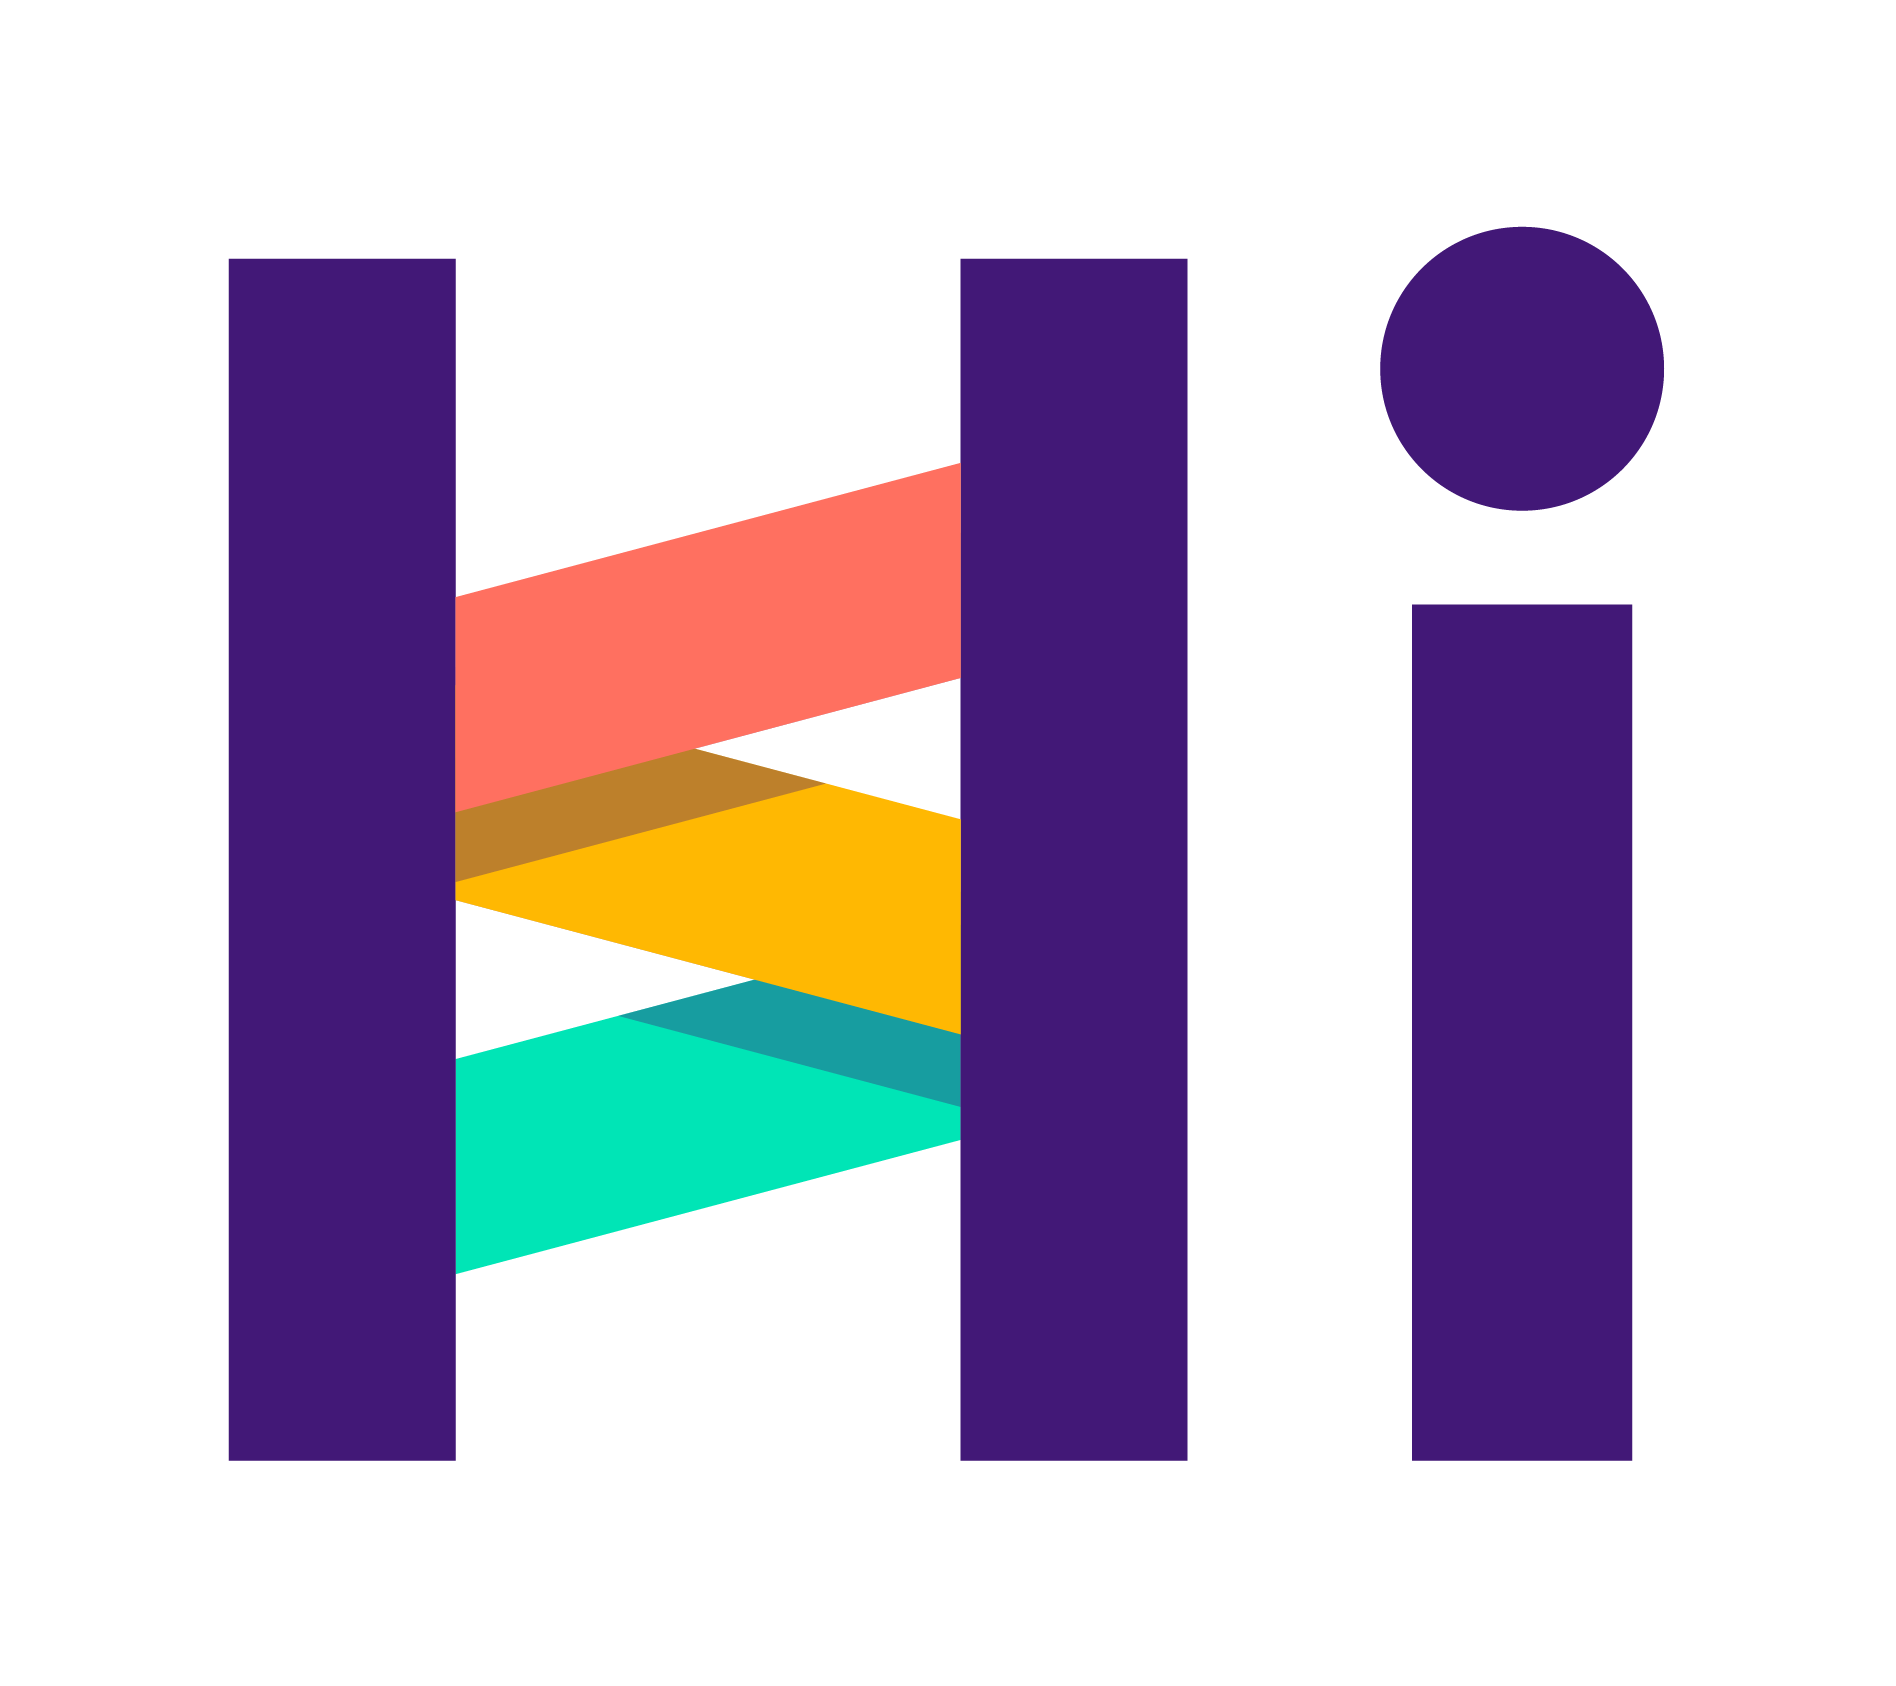

<IPython.core.display.Javascript object>

In [37]:
hip.Experiment.from_iterable(hip1).display(force_full_width=False)

In [77]:
np.random.seed(300)
tf.compat.v1.random.set_random_seed(2005)

learn = 0.01
opt = tf.optimizers.Adam(lr= learn, amsgrad = True)
#opt = tf.optimizers.Adadelta(lr= learn)

loss_fctn = 'mean_squared_error'
activ_h = 'tanh'  #selu, tanh
KI_h = 'glorot_uniform'

model = Sequential()
model.add(Dense(100, input_shape=(X_train.shape[1], X_train.shape[2]), activation=activ_h, kernel_initializer=KI_h))
#model.add(Dense(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation=activ_h, kernel_initializer=KI_h))
#model.add(Dense(25, input_shape=(X_train.shape[1], X_train.shape[2]), activation=activ_h, kernel_initializer=KI_h))
model.add(LSTM(32, activation=activ_h, kernel_initializer=KI_h, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), recurrent_dropout = 0.4,dropout=0.4))
model.add(LSTM(32, activation=activ_h, kernel_initializer=KI_h, return_sequences=True, recurrent_dropout = 0.2,   dropout=0.2))
model.add(LSTM(32, activation=activ_h, kernel_initializer=KI_h, return_sequences=True, recurrent_dropout = 0.2,   dropout=0.2))
model.add(LSTM(32))
model.add(Dense(16, input_dim=32, activation=activ_h, kernel_initializer=KI_h))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss=loss_fctn, optimizer=opt,  metrics=['acc', 'mae', 'msle', 'mse'])
 


NameError: name 'X_train' is not defined